Natalia Miela

Pola Parol

Irena Zimovska

# Text mining project 

For our project we chose dataset from Kaggle "Central Bank Speeches". This dataset gathers many speeches from senior central bankers. These speeches may have influence on economic condiotions. Central banks are entities responsible for shaping monetary policy, exerting significant impact on financial markets. Consequently, the speeches made by central bankers are closely monitored and widely observed. Our focus is on speeches from the United States, focusing on a period from 1997 to 2022.

link do dataset: https://www.kaggle.com/datasets/davidgauthier/central-bank-speeches/data

## Data loading

### Libraries

In [49]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from scipy.stats import norm
from sklearn.cluster import MiniBatchKMeans
from wordcloud import WordCloud
from textblob import TextBlob
import seaborn as sns
from sklearn.decomposition import PCA

sns.set_style("white")
plt.style.use('seaborn-v0_8-pastel')

In [50]:
raw_data = pd.read_excel('data/usa.xlsx')

In [51]:
raw_data.shape

(1551, 7)

In [52]:
raw_data.head(15)

,reference,country,date,title,author,is_gov,text
0,r970105a_FOMC,united states,1997-01-05,I. Structural Models and Monetary Policy Analysis,meyer,0,I am in the middle of my third interesting and...
1,r970114a_FOMC,united states,1997-01-14,National Bank of Belgium,greenspan,1,"Mr. Prime Minister, Minister of Finance, Minis..."
2,r970116a_FOMC,united states,1997-01-16,Balanced Risks Going Forward,meyer,0,Measured on a fourth quarter to fourth quarter...
3,r970124a_FOMC,united states,1997-01-24,Activities,meyer,0,My topic this morning is financial modernizati...
4,r970128a_FOMC,united states,1997-01-28,should,phillips,0,Good afternoon. It is a pleasure to be here to...
5,r970129a_FOMC,united states,1997-01-29,"So, is the liquidity transformation function o...",kelley,0,I would like to say first that it is a pleasur...
6,r970214a_FOMC,united states,1997-02-14,one,phillips,0,It is a great pleasure to have the opportunity...
7,r970221a_FOMC,united states,1997-02-21,Government regulation and derivative contracts,greenspan,1,Government regulation and derivative contracts...
8,r970303a_FOMC,united states,1997-03-03,Supervisory Changes,phillips,0,I am pleased to have the opportunity to addres...
9,r970307a_FOMC,united states,1997-03-07,Privacy in the information age,greenspan,1,Privacy in the information age It is a pleasur...


## Exploring texts

Let's take a look and see how speeches look like. We can see that most of the speeches are formal.

In [53]:
for speech in raw_data['text'].head(5):
    words = speech.split()[:100]  
    truncated_text = ' '.join(words) 
    print(truncated_text)
    print("\n")


I am in the middle of my third interesting and active encounter with the development and/or use of macroeconometric models for forecasting and policy analysis. My journey began at MIT as a research assistant to Professors Franco Modigiliani and Albert Ando during the period of development of the MPS model, continued at Laurence H. Meyer & Associates with the development of The Washington University Macro Model under the direction of my partner, Joel Prakken, and the use of that model for both forecasting and policy analysis, and now has taken me to the Board of Governors where macro models have


Mr. Prime Minister, Minister of Finance, Minister of Budget, Rector Oosterlinck, Professor Peeters, ladies and gentlemen, it is a distinct honor, and a great personal pleasure, to be here today to receive this degree from such a distinguished and historic university. Central bankers, because of the continuity of our institutions and the nature of our responsibilities, typically are said to tak

### Speeches length

Before text processing let's take a look what is the distrubition of the speeches' length. The distribution appears to somewhat resemble a normal distribution.

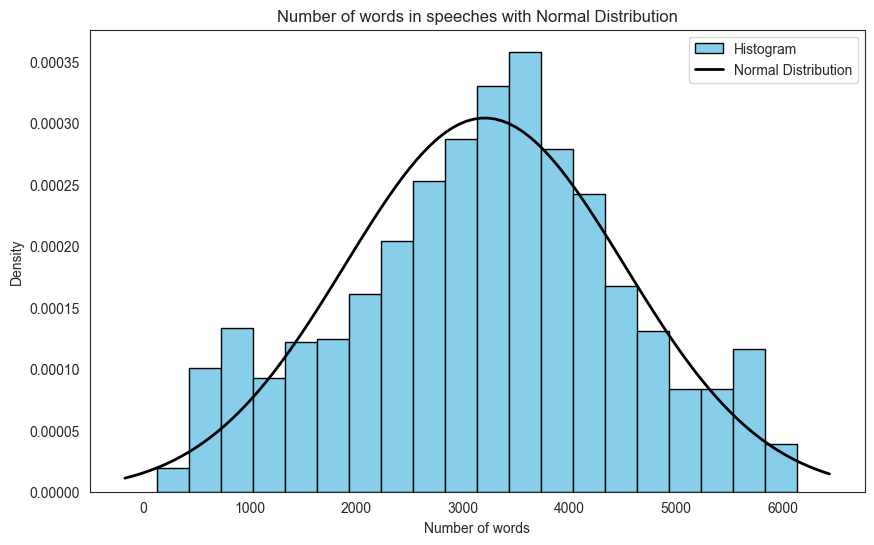

In [54]:
raw_data['word_count'] = raw_data['text'].apply(lambda x: len(word_tokenize(x)))

plt.figure(figsize=(10, 6))
plt.hist(raw_data['word_count'], bins=20, color='skyblue', edgecolor='black', density=True, label='Histogram')

mu, std = raw_data['word_count'].mean(), raw_data['word_count'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

plt.title('Number of words in speeches with Normal Distribution')
plt.xlabel('Number of words')
plt.ylabel('Density')
plt.legend()
plt.show()

## Text processing 

In [55]:
# NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Lemmatizer and get English stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/polaparol/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/polaparol/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [56]:
def preprocess_text(text):
    
    # Tokenization and lowercasing
    tokens = re.findall(r'\b\w+\b', text.lower())

    # Remove punctuation and stopwords, and lemmatize
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation])


In [57]:
# Apply preprocessing to all text columns
for column in ['title','text']:
    if raw_data[column].dtype == object:  # Checking if the column is of text type
        raw_data[column + '_processed'] = raw_data[column].astype(str).apply(preprocess_text)


We can see what's the difference after applying functions.

In [58]:
raw_data[['title', 'title_processed']]

,title,title_processed
0,I. Structural Models and Monetary Policy Analysis,structural model monetary policy analysis
1,National Bank of Belgium,national bank belgium
2,Balanced Risks Going Forward,balanced risk going forward
3,Activities,activity
4,should,
...,...,...
1546,Restoring Price Stability in an Uncertain Econ...,restoring price stability uncertain economic e...
1547,Managing the Promise and Risk of Financial Inn...,managing promise risk financial innovation
1548,Forward Guidance as a Monetary Policy Tool: Co...,forward guidance monetary policy tool consider...
1549,The U.S. Dollar and Central Bank Digital Curre...,u dollar central bank digital currency


In [59]:
raw_data[['text', 'text_processed']]

,text,text_processed
0,I am in the middle of my third interesting and...,middle third interesting active encounter deve...
1,"Mr. Prime Minister, Minister of Finance, Minis...",mr prime minister minister finance minister bu...
2,Measured on a fourth quarter to fourth quarter...,measured fourth quarter fourth quarter basis a...
3,My topic this morning is financial modernizati...,topic morning financial modernization financia...
4,Good afternoon. It is a pleasure to be here to...,good afternoon pleasure today discus topic bec...
...,...,...
1546,It is a pleasure to join this discussion today...,pleasure join discussion today inflation high ...
1547,"Thank you, Chris, and thank you for the invita...",thank chris thank invitation speak today oppor...
1548,Thanks to the Money Marketeers for inviting me...,thanks money marketeers inviting share perspec...
1549,"Thank you, Professor Jackson, and thank you to...",thank professor jackson thank invitation speak...


In [60]:
# Print rows with NAs in raw_data
rows_with_na = raw_data[raw_data.isna().any(axis=1)]
rows_with_na

,reference,country,date,title,author,is_gov,text,word_count,title_processed,text_processed


In [61]:
# Counting the number of observations under each author
author_counts = raw_data['author'].value_counts()
author_counts

bernanke     209
greenspan    159
ferguson     119
brainard     104
powell        98
bies          76
kohn          75
meyer         67
yellen        65
gramlich      56
quarles       55
tarullo       54
olson         45
fischer       45
kroszner      44
duke          44
clarida       42
bowman        41
mishkin       27
warsh         18
raskin        17
waller        17
stein         16
no_info       16
rivlin        15
phillips      10
kelley         9
reinhart       2
barr           2
madigan        1
sack           1
jefferson      1
cook           1
Name: author, dtype: int64

In [62]:
raw_data.columns

Index(['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
       'word_count', 'title_processed', 'text_processed'],
      dtype='object')

In [63]:
data = raw_data[['date', 'title_processed', 'author', 'is_gov',
                 'text_processed']]

## Text clustering

We decided to explore data and check what were the main topics for all the speaches. Maybe there were couple of main subjects? Based on the elbow rule, data was divided into 6 clusters. Based on the text clustering we could distinguish 6 groups of speeches main topic:

**Cluster 0:**

Topics: Productivity, monetary policy, inflation, labor market, economic growth.

Comment: This cluster mainly focuses on macroeconomic indicators such as productivity, economic growth, and inflation, as well as factors related to monetary policy and the labor market.

**Cluster 1:**

Topics: Financial risk, mortgage loans, credit market, foreclosure.

Comment: This cluster concentrates on issues related to financial risk, including mortgage loans, the credit market, foreclosure risks, and housing market issues.

**Cluster 2:**

Topics: Bank capital, liquidity, risk, financial crisis.

Comment: This cluster covers topics related to bank capital, liquidity, risk, and financial stress, suggesting it may relate to the financial condition of banking institutions.

**Cluster 3:**

Topics: Currency, risk, monetary policy, technology, banking.

Comment: This cluster encompasses diverse topics such as currency, risk, monetary policy, and technology, suggesting it may involve issues related to international financial relations and banking.

**Cluster 4:**

Topics: Social development programs, small business loans, financial education.

Comment: This cluster focuses on social and developmental issues such as social development programs, financial education, and small business loans, suggesting it may involve social policies and support for entrepreneurship.

**Cluster 5:**

Topics: Regulatory supervision, risk management, banking.

Comment: This cluster centers on topics related to regulatory supervision, risk management, and banking, suggesting it may pertain to regulatory standards and oversight in the financial sector.


Cluster analysis has allowed us to gain a deeper understanding of the content within our dataset. Despite the clusters appearing to have similar themes, we can differentiate and categorize the topics of the speeches into various domains. These domains include monetary policy, financial risk, bank capital, currency, social programs, and regulations regarding risk management. Through this analysis, we can gain a better understanding of the key interests and priorities in the field of banking and finance as reflected in the speech texts.

In [64]:
# Tf idf
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(raw_data.text_processed)
text = tfidf.transform(raw_data.text_processed)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


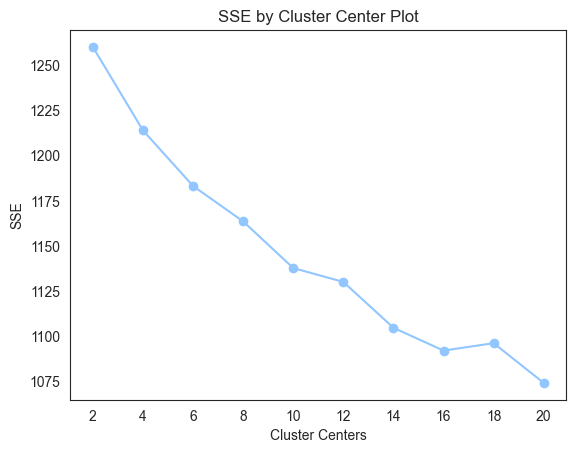

In [65]:
# look for optimal no of clusters
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

In [66]:
clusters = MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

In [67]:
cluster_counts = np.bincount(clusters)

print("Number of clusters in each cluster")
for cluster_id, count in enumerate(cluster_counts):
    print(f"Cluster {cluster_id}: {count} speeches")

Number of clusters in each cluster
Cluster 0: 462 speeches
Cluster 1: 87 speeches
Cluster 2: 227 speeches
Cluster 3: 386 speeches
Cluster 4: 217 speeches
Cluster 5: 172 speeches


In [68]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i, r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

feature_names = tfidf.get_feature_names_out()

get_top_keywords(text, clusters, feature_names, 15)



Cluster 0
term,productivity,federal,economic,fomc,labor,percent,growth,market,economy,monetary,price,policy,rate,inflation

Cluster 1
servicers,financial,rate,lending,lender,subprime,consumer,market,credit,borrower,foreclosure,housing,home,loan,mortgage

Cluster 2
funding,reserve,federal,asset,stress,institution,credit,crisis,capital,liquidity,firm,risk,bank,market,financial

Cluster 3
trade,capital,currency,federal,reserve,technology,policy,rate,economic,country,bank,economy,payment,market,financial

Cluster 4
program,local,development,income,credit,loan,federal,reserve,education,small,financial,business,cra,bank,community

Cluster 5
regulatory,supervisory,market,internal,institution,ii,supervisor,organization,financial,capital,management,basel,banking,risk,bank


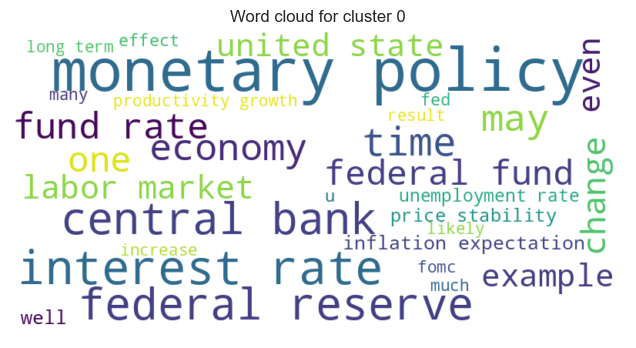

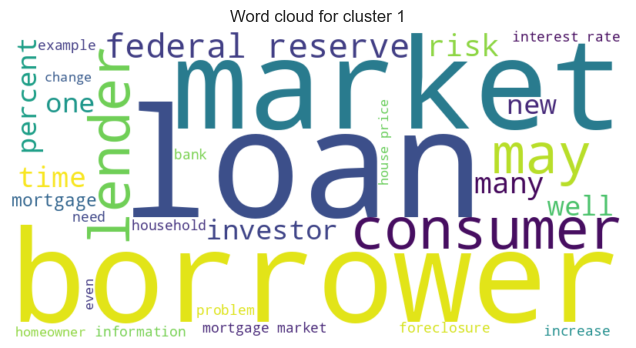

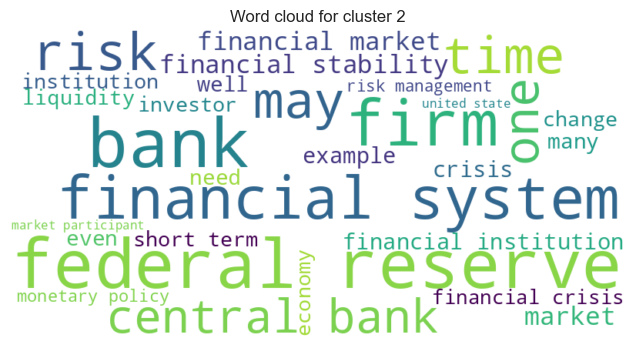

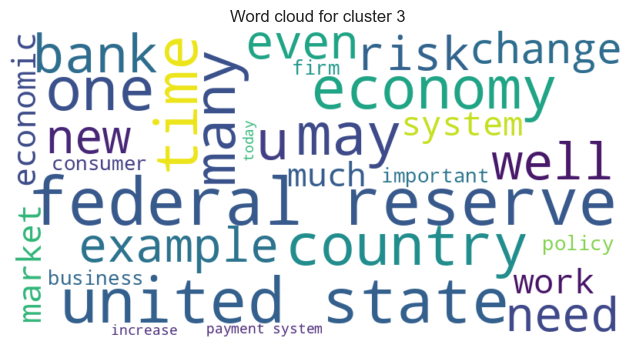

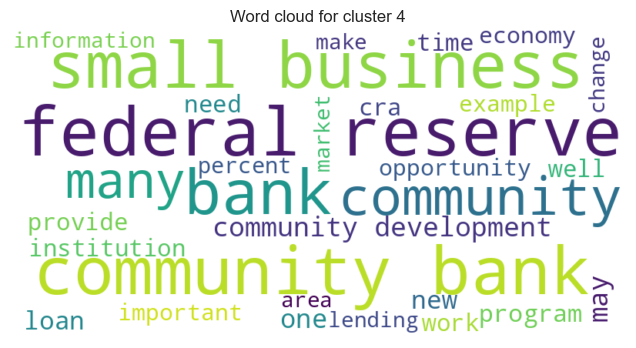

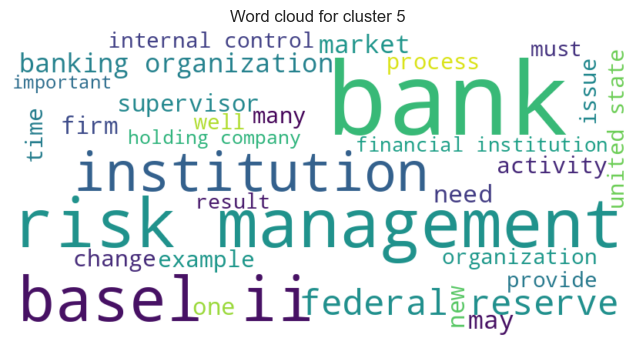

In [69]:
def generate_word_cloud(texts, cluster_id):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=30).generate(' '.join(texts))
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word cloud for cluster {cluster_id}")
    plt.axis('off')
    plt.show()

for cluster_id in range(6):
    cluster_texts = raw_data[clusters == cluster_id]['text_processed']
    #print(f"Word cloud for cluster {cluster_id}:")
    generate_word_cloud(cluster_texts, cluster_id)


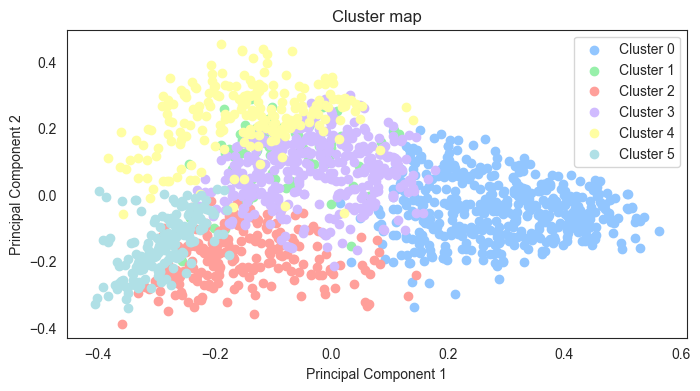

In [70]:
pca = PCA(n_components=2)
text_pca = pca.fit_transform(text.toarray())

plt.figure(figsize=(8, 4))
for cluster_id in range(6):
    plt.scatter(text_pca[clusters == cluster_id, 0], text_pca[clusters == cluster_id, 1], label=f'Cluster {cluster_id}')

plt.title('Cluster map')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


## Sentiment analysis

In addition to clustering analysis, we conducted sentiment analysis on the speeches to gain insights into the overall tone and sentiment conveyed by central bank communications. Sentiment analysis allows us to systematically evaluate the emotional tone of the speeches and identify any underlying patterns or trends.

In [71]:
# Sentiment analysis
# Apply sentiment analysis using TextBlob

data['sentiment'] = data['text_processed'].apply(lambda x: TextBlob(x).sentiment.polarity)

/var/folders/r6/7ckwh6lx77d_z3w19r_qvlhm0000gn/T/ipykernel_12818/3088580585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data['text_processed'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [72]:
data

,date,title_processed,author,is_gov,text_processed,sentiment
0,1997-01-05,structural model monetary policy analysis,meyer,0,middle third interesting active encounter deve...,0.103412
1,1997-01-14,national bank belgium,greenspan,1,mr prime minister minister finance minister bu...,0.083020
2,1997-01-16,balanced risk going forward,meyer,0,measured fourth quarter fourth quarter basis a...,0.067790
3,1997-01-24,activity,meyer,0,topic morning financial modernization financia...,0.061372
4,1997-01-28,,phillips,0,good afternoon pleasure today discus topic bec...,0.115208
...,...,...,...,...,...,...
1546,2022-10-10,restoring price stability uncertain economic e...,brainard,0,pleasure join discussion today inflation high ...,0.094385
1547,2022-10-12,managing promise risk financial innovation,barr,0,thank chris thank invitation speak today oppor...,0.111788
1548,2022-10-12,forward guidance monetary policy tool consider...,bowman,0,thanks money marketeers inviting share perspec...,0.097588
1549,2022-10-14,u dollar central bank digital currency,waller,0,thank professor jackson thank invitation speak...,0.055939


In [73]:
# Aggregate sentiment by year
data['year'] = data['date'].dt.year
yearly_sentiment = data.groupby('year')['sentiment'].mean().reset_index()
yearly_sentiment

/var/folders/r6/7ckwh6lx77d_z3w19r_qvlhm0000gn/T/ipykernel_12818/2948857104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['date'].dt.year


,year,sentiment
0,1997,0.096026
1,1998,0.093835
2,1999,0.093923
3,2000,0.104872
4,2001,0.084147
5,2002,0.097479
6,2003,0.096647
7,2004,0.095090
8,2005,0.099542
9,2006,0.110609


In [74]:
# Aggregate sentiment by author
author_sentiment = data.groupby('author')['sentiment'].mean().reset_index()
author_sentiment

,author,sentiment
0,barr,0.086306
1,bernanke,0.099925
2,bies,0.109108
3,bowman,0.125064
4,brainard,0.097081
5,clarida,0.104187
6,cook,0.088576
7,duke,0.094530
8,ferguson,0.092850
9,fischer,0.077781


In [75]:
sorted_data = data.sort_values(by='sentiment', ascending=False)
top_speeches = sorted_data.head(20)
top_speeches

,date,title_processed,author,is_gov,text_processed,sentiment,year
611,2006-02-06,remark ceremonial swearing president bush,bernanke,1,federal reserve central bank united state prov...,0.290242,2006
1299,2018-09-27,brief remark u economy,powell,1,good afternoon thank senator reed kind word op...,0.261834,2018
521,2004-11-18,fair value measurement issue warrant considera...,bies,0,good morning appreciate opportunity participat...,0.261638,2004
1089,2014-03-25,remark woman history month,yellen,1,honor pleasure mark woman history month histor...,0.251884,2014
1115,2014-10-30,welcoming remark,yellen,1,federal reserve board organized conference imp...,0.251199,2014
1376,2019-10-01,introductory remark,clarida,0,good morning welcome federal reserve board res...,0.243456,2019
1540,2022-09-28,welcoming remark,powell,1,release delivery good morning welcome 10th ann...,0.237879,2022
1522,2022-05-24,welcoming remark,powell,1,good morning welcome great pleasure welcome at...,0.228561,2022
907,2010-05-08,economics happiness,bernanke,1,want begin thanking board trustee university s...,0.218539,2010
1086,2014-03-05,remark ceremonial swearing,yellen,1,good afternoon thank dan thank everyone gather...,0.215357,2014


In [76]:
pd.to_datetime(top_speeches['date'], format='%Y-%m-%d')
top_speeches

,date,title_processed,author,is_gov,text_processed,sentiment,year
611,2006-02-06,remark ceremonial swearing president bush,bernanke,1,federal reserve central bank united state prov...,0.290242,2006
1299,2018-09-27,brief remark u economy,powell,1,good afternoon thank senator reed kind word op...,0.261834,2018
521,2004-11-18,fair value measurement issue warrant considera...,bies,0,good morning appreciate opportunity participat...,0.261638,2004
1089,2014-03-25,remark woman history month,yellen,1,honor pleasure mark woman history month histor...,0.251884,2014
1115,2014-10-30,welcoming remark,yellen,1,federal reserve board organized conference imp...,0.251199,2014
1376,2019-10-01,introductory remark,clarida,0,good morning welcome federal reserve board res...,0.243456,2019
1540,2022-09-28,welcoming remark,powell,1,release delivery good morning welcome 10th ann...,0.237879,2022
1522,2022-05-24,welcoming remark,powell,1,good morning welcome great pleasure welcome at...,0.228561,2022
907,2010-05-08,economics happiness,bernanke,1,want begin thanking board trustee university s...,0.218539,2010
1086,2014-03-05,remark ceremonial swearing,yellen,1,good afternoon thank dan thank everyone gather...,0.215357,2014


In [77]:
# Filter for rows with negative sentiment
negative_sentiment_data = data[data['sentiment'] < 0]
negative_sentiment_data

,date,title_processed,author,is_gov,text_processed,sentiment,year
20,1997-05-23,importance bank small business relationship,meyer,0,good afternoon pleasure meet new york universi...,-0.025525,1997
117,1999-03-16,role small business economy,ferguson,0,pleased evening wish thank national black busi...,-0.023399,1999
353,2002-12-13,credit availability small business,bies,0,good morning everyone would like thank barbara...,-0.021223,2002
512,2004-10-15,oil,no_info,0,owing current turmoil oil market number analys...,-0.013857,2004
955,2011-04-14,small business credit availability,duke,0,pleasure morning appreciate opportunity take p...,-0.012301,2011
1038,2013-03-04,ending big fail,powell,1,today discus big fail ongoing work since finan...,-0.021017,2013
1193,2016-06-22,comment resolution framework bank bank holding...,fischer,0,would like briefly describe legal framework ex...,-0.062502,2016


In [78]:
# Calculate the range of sentiment scores for each year
sentiment_variability = data.groupby('year')['sentiment'].agg(['min', 'max'])
sentiment_variability['range'] = sentiment_variability['max'] - sentiment_variability['min']

sentiment_variability

,min,max,range
year,,,
1997,-0.025525,0.167564,0.193088
1998,0.034008,0.163001,0.128993
1999,-0.023399,0.204701,0.228099
2000,0.035398,0.198452,0.163053
2001,0.033592,0.159113,0.125520
2002,-0.021223,0.200829,0.222052
2003,0.019318,0.181147,0.161829
2004,-0.013857,0.261638,0.275495
2005,0.027697,0.187389,0.159692


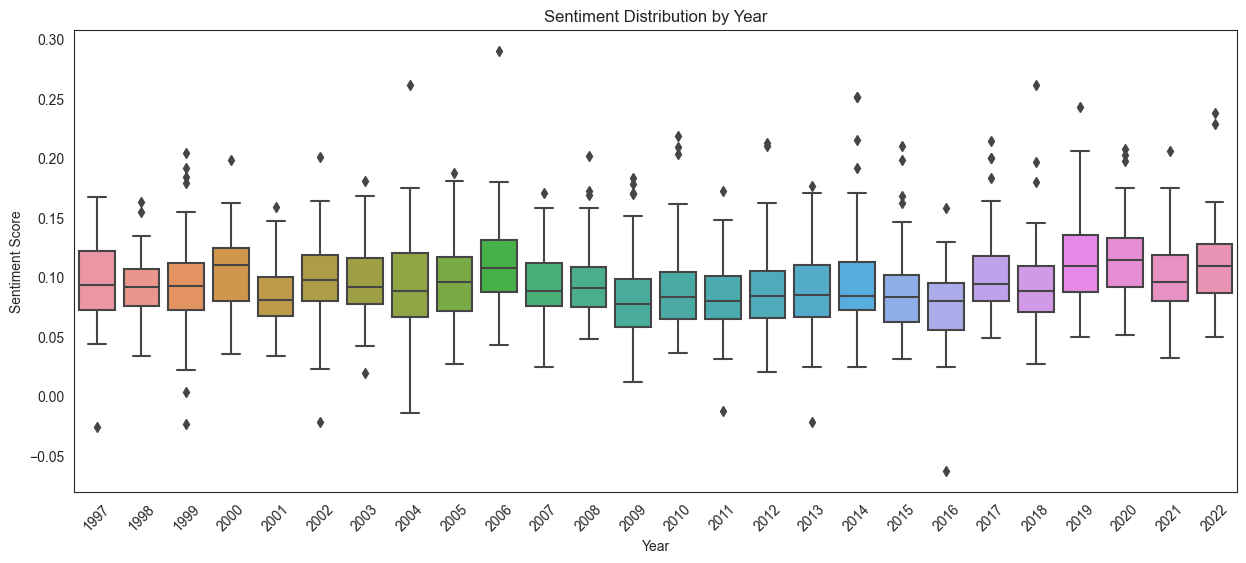

In [79]:
# Plots sentiment
# Sentiment Distribution Plots for Each Year

plt.figure(figsize=(15, 6))
sns.boxplot(x='year', y='sentiment', data=data)
plt.title('Sentiment Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.show()

The median sentiment score and their variance appears relatively stable over the years, with slight fluctuations. It suggests that the overall sentiment of the speeches does not undergo drastic changes year over year. 

The median sentiment scores for the years 2001, 2009, 2016 and 2021 are notably lower than for other years. This drop in sentiment could correspond to challenging economic times or events that influenced a more cautious or negative tone in the speeches.
In 2001, the dot-com bubble had recently burst, leading to economic downturns and likely a more low sentiment in central bank communications.
The year 2009 was in the aftermath of the 2008 global financial crisis, a period marked by economic recession and uncertainty, which is reflected in the lower sentiment scores.
For 2016, the lower median could be associated with the economic and financial uncertainties surrounding events like the Brexit referendum and the U.S. presidential election that year. 
For 2021, the lower median sentiment score may reflect the ongoing challenges and economic uncertainty as the world continued to fight with the effects of the COVID-19 pandemic. 

Some years, like 2000, 2006, and 2019, exhibit higher median sentiment scores, which might align with periods of relative economic optimism or recovery. 
The year 2000 was at the height of the dot-com boom, just before the bubble burst, a period marked by high economic enthusiasm and investment in technology sectors, which could explain the optimistic sentiment.
In 2006, the economy was in the midst of a housing boom and prior to the financial crisis, which might account for the positive sentiment reflected in the central bank speeches as economic conditions were perceived as strong.
The year 2019 showed a rebound in sentiment, possibly reflecting the recovery and growth following the financial stabilization after the 2008 crisis and the continued economic expansion leading up to the COVID-19 pandemic.

There are a number of outlier points every year, indicating speeches with sentiment scores that significantly deviate from the majority. The range of sentiment scores within the interquartile range and the lengths of the whiskers vary from year to year. This suggests that the variability of sentiment in the speeches is not consistent over time.


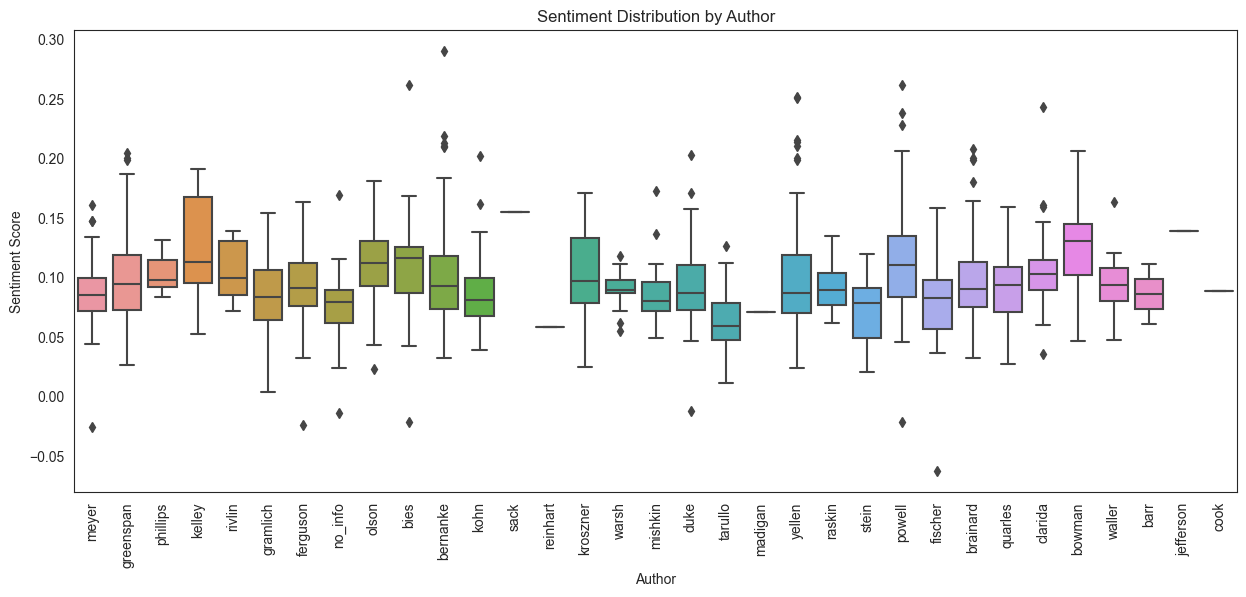

In [80]:
# Sentiment Distribution Plots for Each Author
plt.figure(figsize=(15, 6))
sns.boxplot(x='author', y='sentiment', data=data)
plt.title('Sentiment Distribution by Author')
plt.xlabel('Author')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=90)
plt.show()


The medians are above zero for all authors, indicating a generally neutral to positive sentiment across the board. Some authors show higher median sentiment scores than others, which may reflect their individual communication styles or the economic circumstances during their period of speeches. Kelley, Bies, Olson, Powell and Bowman has a higher median sentiment score compared to other authors. This suggests that their speeches generally conveyed a more positive tone. 

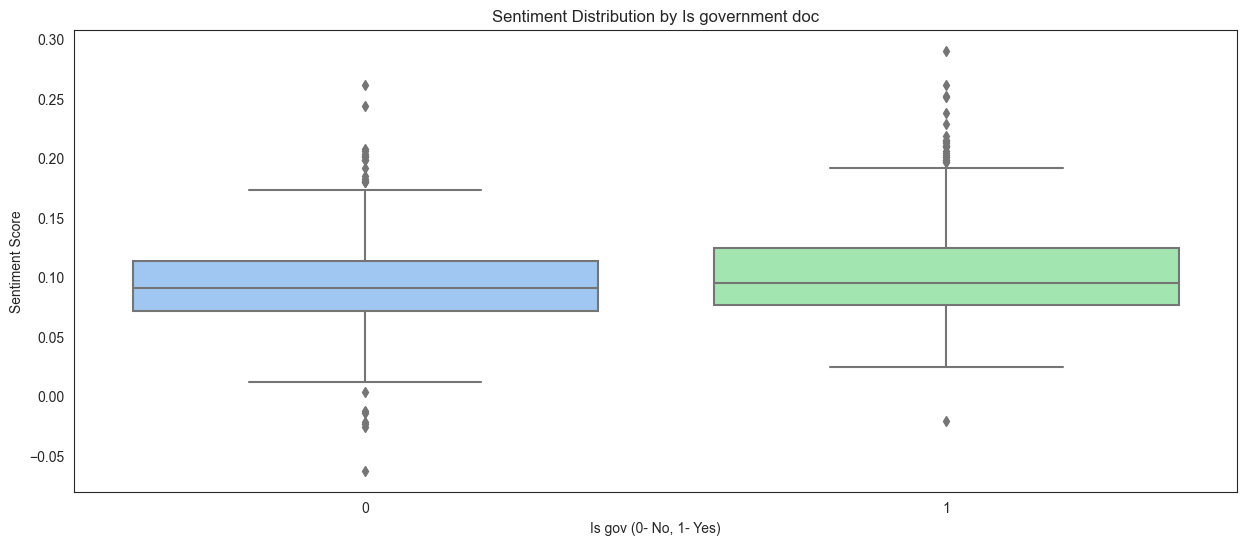

In [81]:
# Sentiment Distribution Plots for Is gov (governmnet doc)
plt.figure(figsize=(15, 6))
sns.boxplot(x='is_gov', y='sentiment', data=data)
plt.title('Sentiment Distribution by Is government doc')
plt.xlabel('Is gov (0- No, 1- Yes)')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=0)
plt.show()

Both categories exhibit a generally positive median sentiment score, with the median for government documents (1) slightly higher than for non-government documents (0). This could indicate that government documents tend to have a slightly more positive tone. The range of sentiment scores, as indicated by the length of the boxes and the whiskers, is similar between the two categories, suggesting comparable variability in sentiment. However, there is a noticeable presence of outliers in both categories, especially for government documents, where sentiment scores vary more widely. 

### Autorship Analysis- writing style

In [82]:
# Authorship Analysis- writing style
# Extracting texts for each author
texts_by_author = data.groupby('author')['text_processed'].apply(lambda texts: ' '.join(texts))

# TF-IDF Vectorizer to analyze word choice, sentence structure, etc.
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), min_df=0.1)
tfidf_matrix = tfidf.fit_transform(texts_by_author)

# Converting to df
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=texts_by_author.index, columns=tfidf.get_feature_names_out())

# TF-IDF results
tfidf_df

,00,000,000 average,000 bank,000 community,000 financial,000 household,000 job,000 job month,000 le,...,zero unemployment,zero year,zero zero,zingales,zip,zip code,zone,zone price,zone price stability,zone time
author,,,,,,,,,,,,,,,,,,,,,
barr,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bernanke,0.000000,0.011138,0.000000,0.000000,0.000000,0.000000,0.000919,0.002881,0.000734,0.000163,...,0.000000,0.000154,0.000000,0.000000,0.000325,0.000325,0.003781,0.000368,0.000368,0.000184
bies,0.000000,0.003660,0.000000,0.000297,0.000000,0.000372,0.000000,0.000432,0.000297,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bowman,0.000000,0.010980,0.000000,0.000000,0.000000,0.000000,0.000000,0.002031,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001032,0.001032,0.000727,0.000000,0.000000,0.000000
brainard,0.000000,0.011652,0.000424,0.001082,0.000000,0.000000,0.000452,0.002098,0.000721,0.000400,...,0.000904,0.000758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
clarida,0.000000,0.002058,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004021,0.000000,0.000000,0.000000,0.000000,0.000000,0.002507,0.000000,0.000000,0.000000
cook,0.000000,0.010426,0.000000,0.000000,0.000000,0.000000,0.000000,0.014783,0.020336,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
duke,0.000621,0.013631,0.000694,0.000000,0.000000,0.000000,0.000000,0.000429,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.003927,0.003927,0.000461,0.000000,0.000000,0.000000
ferguson,0.000000,0.008419,0.000000,0.000000,0.000000,0.000697,0.000000,0.000202,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000435,0.000349,0.000349,0.000000


In [83]:
# Choose only authors with more than 100 speeches and vizualize

# Calculate author counts
author_counts = data['author'].value_counts()

# Filter authors with more than 100 entries
authors_more_than_100 = author_counts[author_counts > 100].index.tolist()

filtered_data = data[data['author'].isin(authors_more_than_100)]


# Recalculate TF-IDF for the filtered dataset with adjusted parameters
texts_by_author_filtered = filtered_data.groupby('author')['text_processed'].apply(' '.join)
tfidf_filtered = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), min_df=0.2)
tfidf_matrix_filtered = tfidf_filtered.fit_transform(texts_by_author_filtered)
tfidf_df_filtered = pd.DataFrame(tfidf_matrix_filtered.toarray(), index=texts_by_author_filtered.index,
                                 columns=tfidf_filtered.get_feature_names_out())

# Selecting top N TF-IDF features for each author for visualization
top_n = 10

def get_top_n_features(tfidf_df, n):
    top_features = {}
    for author in tfidf_df.index:
        top_features_for_author = tfidf_df.loc[author].sort_values(ascending=False).head(n)
        top_features[author] = list(top_features_for_author.index)
    return top_features


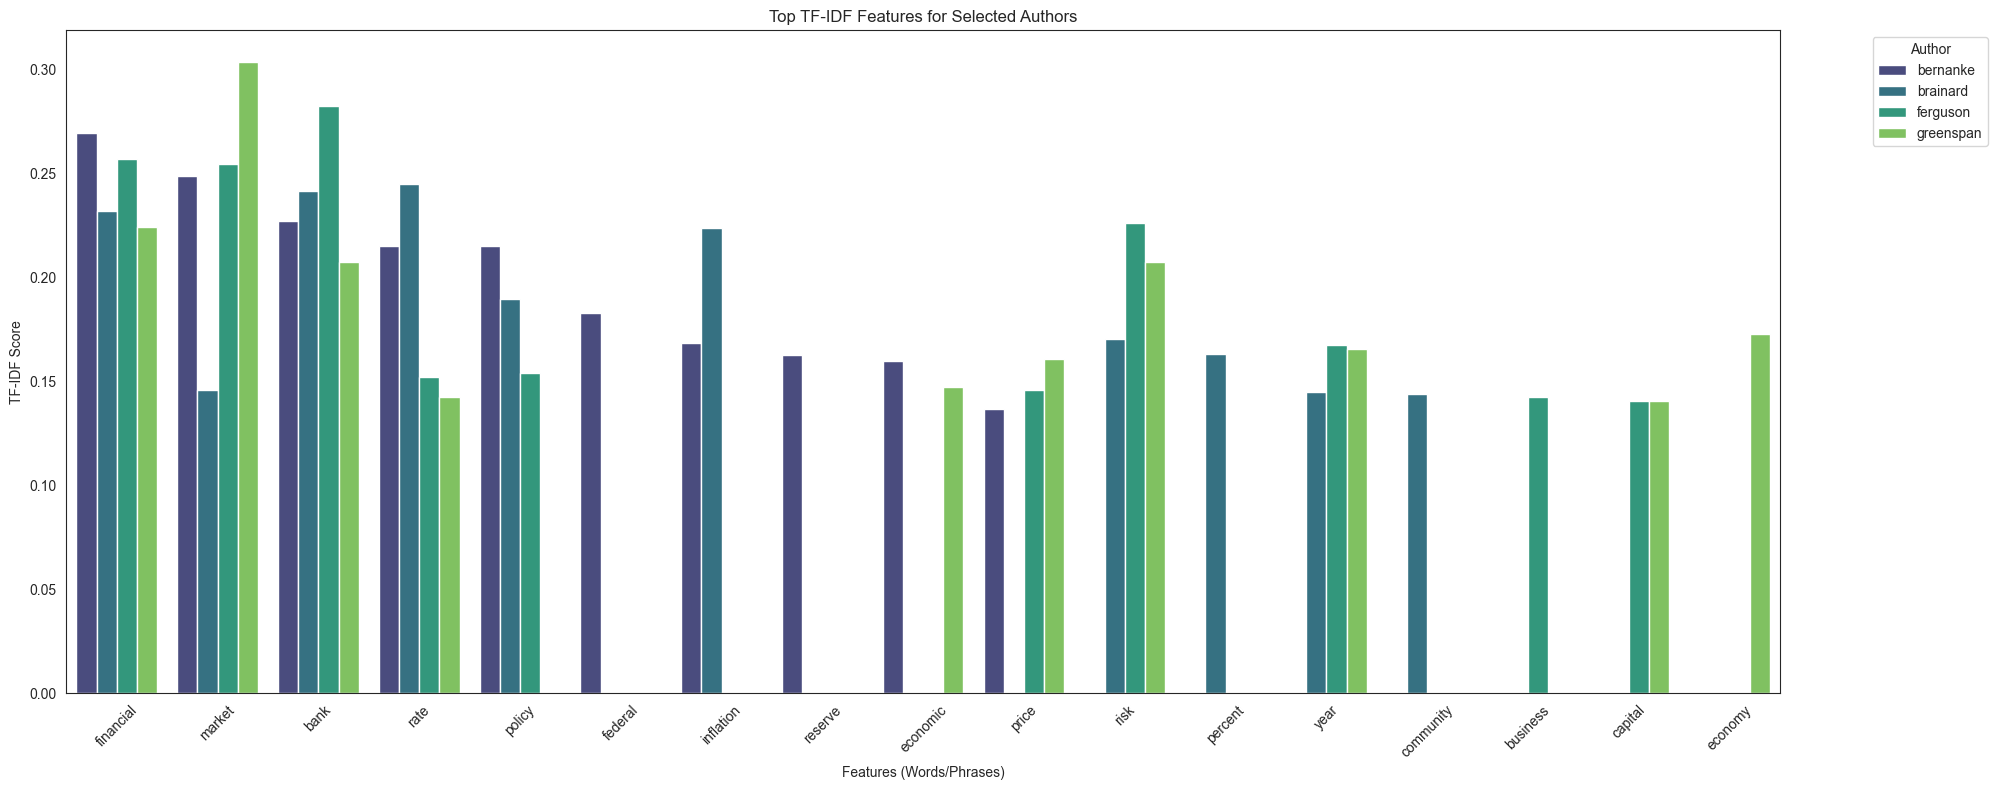

In [84]:
top_features_by_author_filtered = get_top_n_features(tfidf_df_filtered, top_n)

# Prepare data for grouped bar plot
plot_data_filtered = []
for author, features in top_features_by_author_filtered.items():
    for feature in features:
        plot_data_filtered.append({'Author': author, 'Feature': feature,
                                   'TFIDF': tfidf_df_filtered.at[author, feature]})

plot_df_filtered = pd.DataFrame(plot_data_filtered)

# Plotting for the selected authors
plt.figure(figsize=(20, 8))
sns.barplot(x='Feature', y='TFIDF', hue='Author', data=plot_df_filtered, palette='viridis')
plt.title('Top TF-IDF Features for Selected Authors')
plt.xticks(rotation=45)
plt.xlabel('Features (Words/Phrases)')
plt.ylabel('TF-IDF Score')
plt.legend(title='Author', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Certain terms like 'financial', 'market', 'bank', 'rate' are present across all four authors, indicating these are common themes in their speeches. Greenspan's speeches have a notably higher TF-IDF score for the term 'market' suggesting this term is more frequently used and unique to his speeches compared to the others.

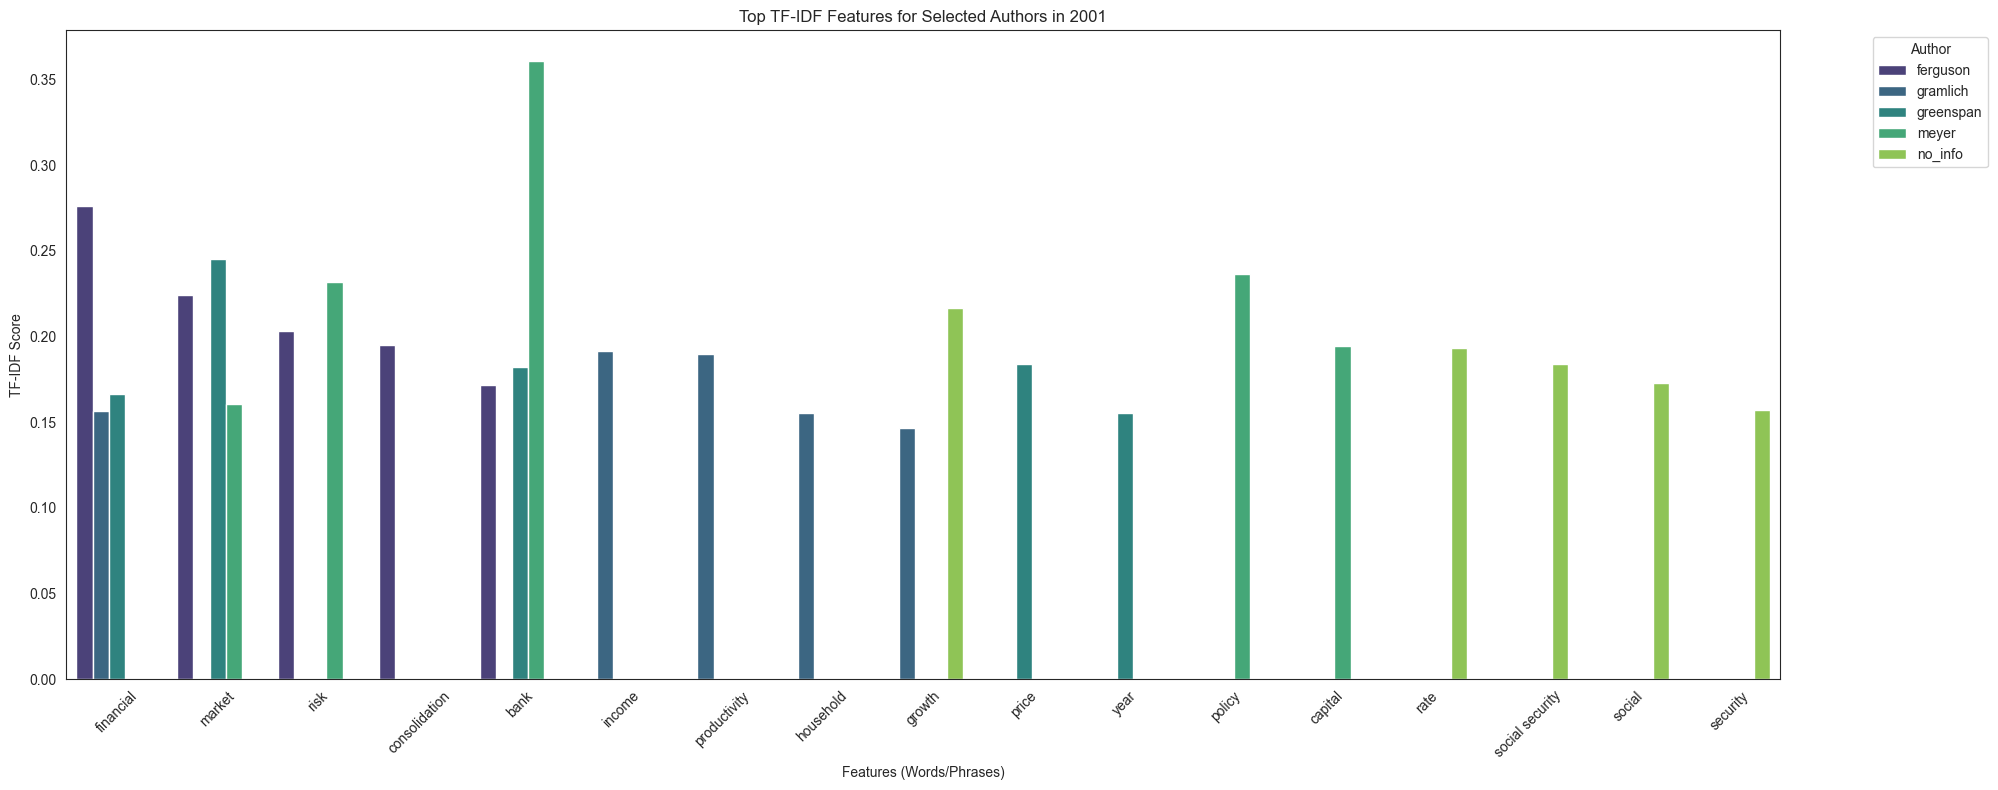

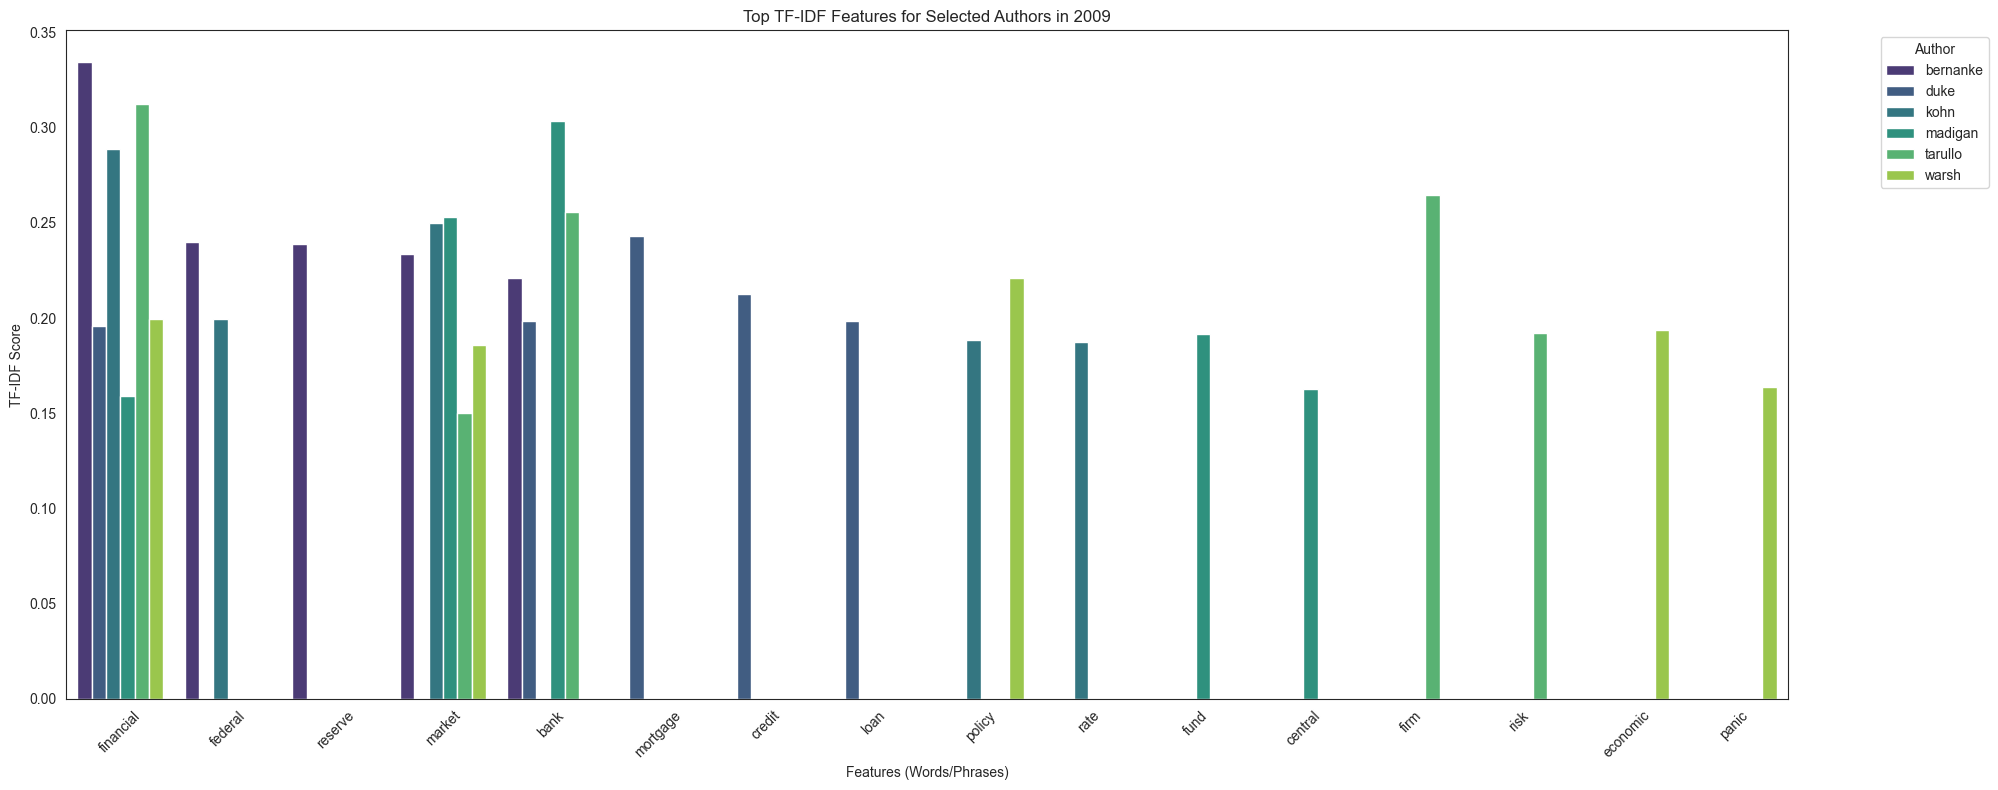

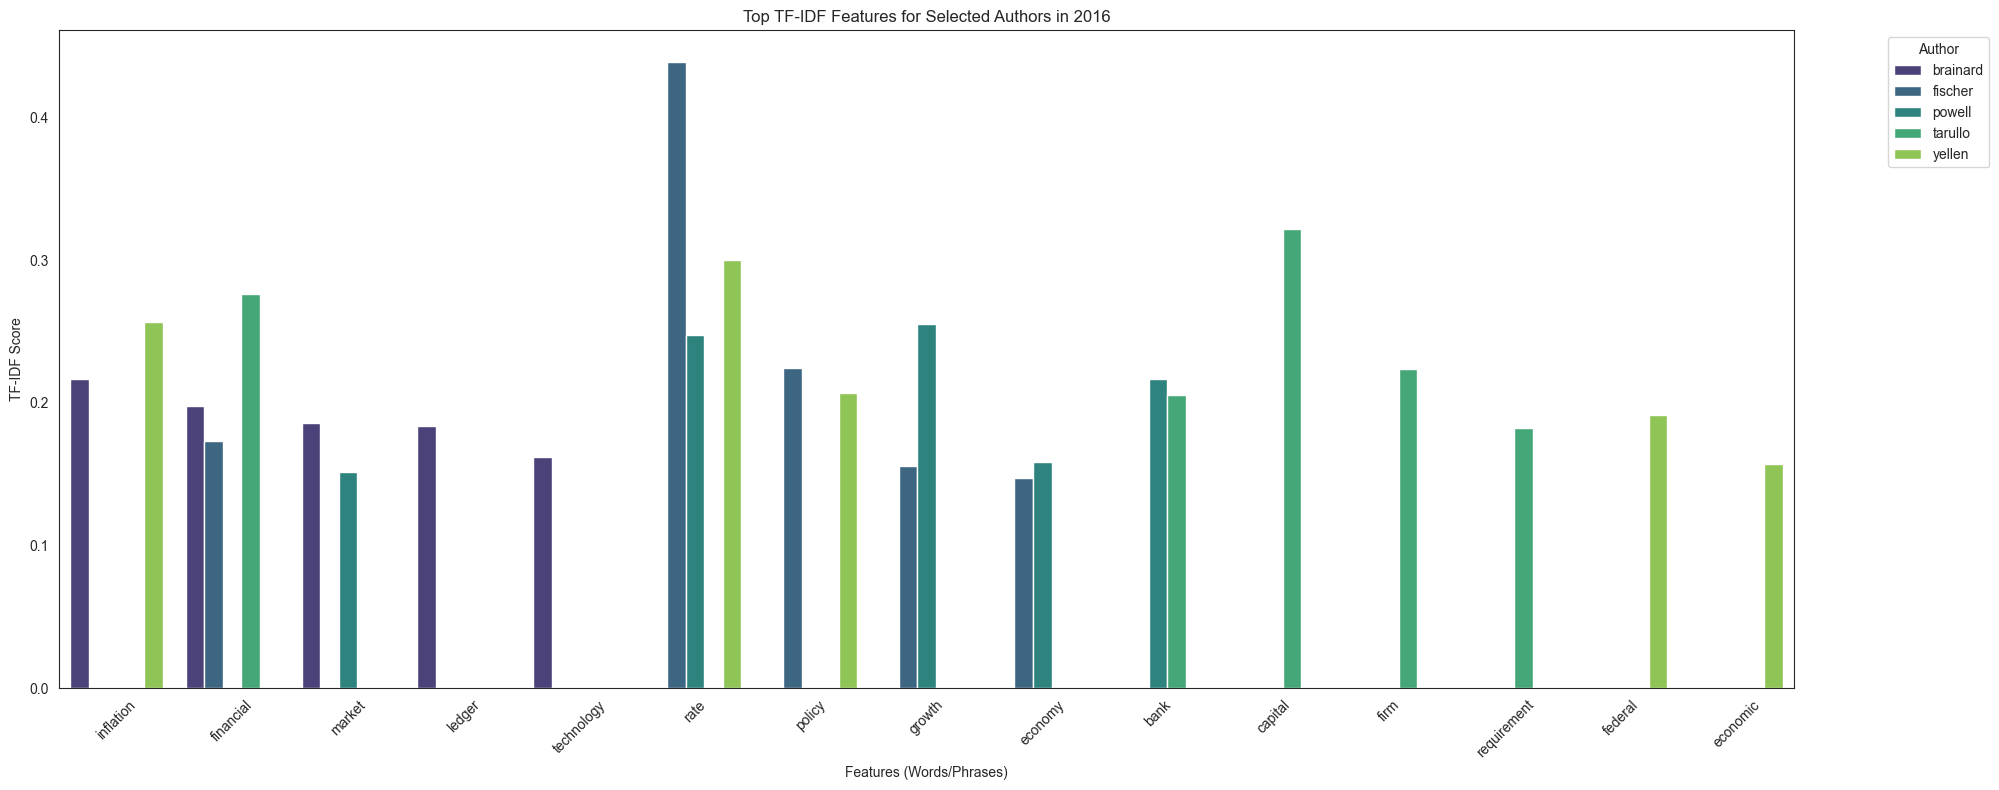

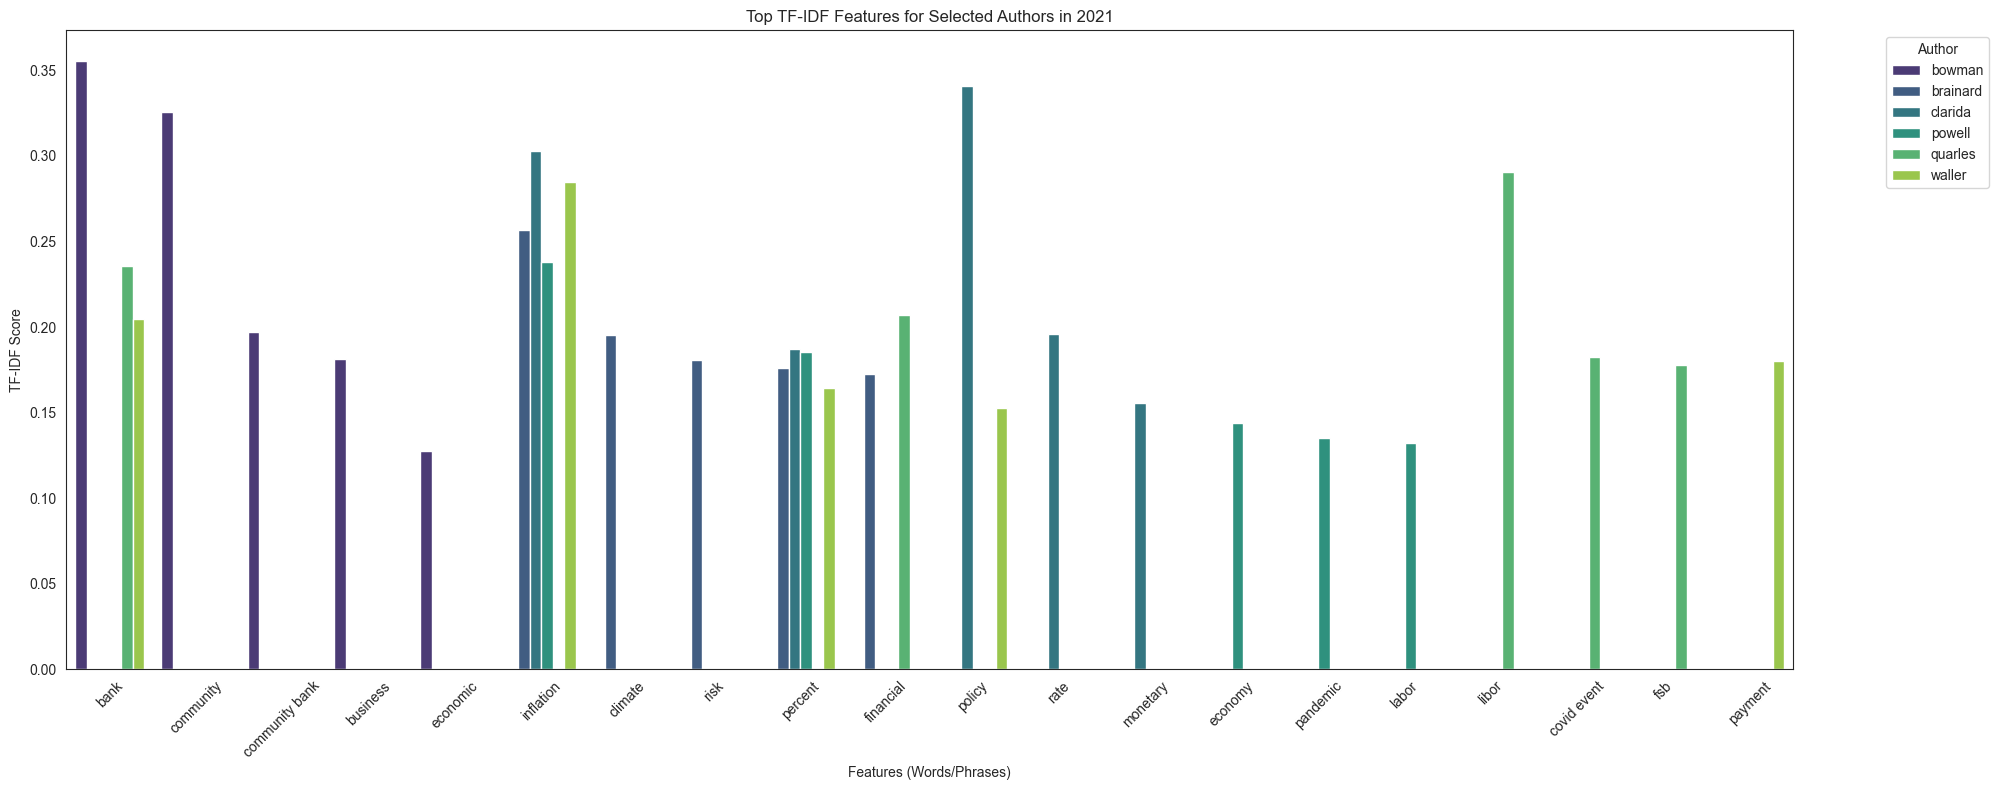

In [85]:
# Filter data and analyze for a subset of years 
selected_years = [2001, 2009, 2016, 2021]

for year in selected_years:
    data_for_year = data[data['year'] == year]
    texts_by_author_for_year = data_for_year.groupby('author')['text_processed'].apply(' '.join)
    tfidf_for_year = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), min_df=0.1)
    tfidf_matrix_for_year = tfidf_for_year.fit_transform(texts_by_author_for_year)
    tfidf_df_for_year = pd.DataFrame(tfidf_matrix_for_year.toarray(), index=texts_by_author_for_year.index,
                                     columns=tfidf_for_year.get_feature_names_out())
    top_features_by_author_for_year = get_top_n_features(tfidf_df_for_year, 5)

    # Prepare and plot data for each year
    plot_data_for_year = [{'Year': year, 'Author': author, 'Feature': feature,
                           'TFIDF': tfidf_df_for_year.at[author, feature]}
                          for author, features in top_features_by_author_for_year.items()
                          for feature in features]
    plot_df_for_year = pd.DataFrame(plot_data_for_year)
    plt.figure(figsize=(20, 8))
    sns.barplot(x='Feature', y='TFIDF', hue='Author', data=plot_df_for_year, palette='viridis')
    plt.title(f'Top TF-IDF Features for Selected Authors in {year}')
    plt.xticks(rotation=45)
    plt.xlabel('Features (Words/Phrases)')
    plt.ylabel('TF-IDF Score')
    plt.legend(title='Author', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


For 2005: 
Terms 'financial', 'market', 'risk', 'bank' are common across multiple authors, indicating these were key topics of discussion in their speeches. Mayer has the highest TF-IDF score for 'bank' which may reflect discussions surrounding banking institutions. The distinctive focus on the terms 'security' and 'social security' within the central banking speeches is possibly in the context of the economic downturn following the dot-com bubble burst.

For 2009: 
All the authors talked a lot about 'financial' and 'market' issues in their speeches. The word 'financial' is the most frequent and unique in Bernanke's speeches, showing that he focused heavily on financial topics during a critical time for the economy. In Duke's speeches, the prominent TF-IDF scores for 'mortgage', 'credit', and 'loan' signal a strong focus on home lending issues, the state of credit markets, and the challenges of loan availability during the economic recovery period.

For 2016: 
Terms 'financial', 'market', 'rate', 'policy', 'growth', 'economy', 'bank' are common across multiple authors, indicating these were key topics of discussion in their speeches. There is a clear focus on regulatory and technological advancements within the financial sector, as well as ongoing discussions about economic growth and policy, reflecting the continuing recovery from the financial crisis and the central bank's role in fostering a stable economic environment.

For 2021:
Terms 'bank', 'inflation', and 'percent' appear across multiple authors' speeches, pointing to a shared focus on banking operations, concerns over inflation rates, and quantitative analysis of economic data. Additionally, terms such as 'covid event', 'ibor', and 'fsb' emerged as unique to this year, reflecting the central banking discourse's adaptation to pandemic-related economic challenges, the transition from interbank offered rates, and engagement with the Financial Stability Board's initiatives.






## SP500 analysis

In addition to conducting clustering and sentiment analysis on central bank speeches, we also investigated whether these speeches have any discernible impact, even small, on the S&P 500 index. This supplementary analysis aims to explore the relationship between central bank communications and market behavior, particularly in the context of one of the most widely followed stock market indices.

Based on the analysis carried out earlier, we selected the days on which speeches with the highest sentiment analysis occurred.

In [86]:
sp500 = pd.read_csv('data/snp500_history.csv')
sp500

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1,1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
2,1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
3,1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
4,1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...,...
23965,2023-05-26 00:00:00-04:00,4156.160156,4212.870117,4156.160156,4205.450195,3715460000,0.0,0.0
23966,2023-05-30 00:00:00-04:00,4226.709961,4231.100098,4192.180176,4205.520020,4228510000,0.0,0.0
23967,2023-05-31 00:00:00-04:00,4190.740234,4195.439941,4166.149902,4179.830078,5980670000,0.0,0.0
23968,2023-06-01 00:00:00-04:00,4183.029785,4232.430176,4171.640137,4221.020020,4391860000,0.0,0.0


In [87]:
sp500['Date'] = pd.to_datetime(sp500['Date'])

In [88]:
sp500['Date'] = sp500['Date'].astype(str)
sp500['Date'] = sp500['Date'].str.extract(r'(\d{4}-\d{2}-\d{2})')
sp500.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


In [89]:
sp500['Daily_Return'] = sp500['Close'].pct_change()
sp500

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0,NaN
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0,0.005663
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0,-0.002252
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0,-0.009594
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0,0.006268
...,...,...,...,...,...,...,...,...,...
23965,2023-05-26,4156.160156,4212.870117,4156.160156,4205.450195,3715460000,0.0,0.0,0.013049
23966,2023-05-30,4226.709961,4231.100098,4192.180176,4205.520020,4228510000,0.0,0.0,0.000017
23967,2023-05-31,4190.740234,4195.439941,4166.149902,4179.830078,5980670000,0.0,0.0,-0.006109
23968,2023-06-01,4183.029785,4232.430176,4171.640137,4221.020020,4391860000,0.0,0.0,0.009854


#### Exploring possible speech impact on the SP500 index

##### Impact on the same day that speech was

In [90]:
dates_of_interest = ['2006-02-06', '2018-09-27', '2004-11-18', '2014-03-25', '2014-10-30',
                      '2019-10-01', '2022-09-28', '2022-05-24', '2010-05-08', '2014-03-05',
                      '2017-01-12', '2012-08-06', '2015-09-30', '2012-07-24', '2010-04-13',
                      '2020-05-05', '2019-04-02', '2021-11-09', '1999-06-10', '2010-04-08',
                      '2020-05-21', '2008-04-07', '2002-11-18', '2017-10-04', '2017-07-28']

list_of_returns = []

for date in dates_of_interest:
    specific_date = date
    selected_data = sp500[sp500['Date'] == specific_date]

    if not selected_data.empty:
        daily_return_for_date = selected_data['Daily_Return'].values[0]
        print(daily_return_for_date)
    else:
        print('no data')
    list_of_returns.append(daily_return_for_date)



0.0007832015153355076
0.0027632870875580196
0.0013622582378927106
0.004403939814465518
0.0062301242403934864
-0.012258373372913245
0.019672139926234733
-0.008120797617175213
no data
-5.335132643191631e-05
-0.0021448089967596173
0.0023292692665812798
0.019075555906861608
-0.009040932945028057
0.0006854008197059169
0.009040556385797371
1.745570720723677e-05
-0.003498775895770745
-0.011997260953432232
0.003374341747336196
-0.007773596407737116
0.0015615985189088022
-0.010408572546959705
0.0012467201713795006
-0.001341115577770502


##### Impact on the day after speech day

In [91]:
dates_of_interest = ['2006-02-07', '2018-09-28', '2004-11-19', '2014-03-26', '2014-10-31',
                      '2019-10-02', '2022-09-29', '2022-05-25', '2010-05-09', '2014-03-06',
                      '2017-01-13', '2012-08-07', '2015-10-01', '2012-07-25', '2010-04-14',
                      '2020-05-06', '2019-04-03', '2021-11-10', '1999-06-11', '2010-04-09',
                      '2020-05-22', '2008-04-08', '2002-11-19', '2017-10-05', '2017-07-29']

list_of_returns = []

for date in dates_of_interest:
    specific_date = date
    selected_data = sp500[sp500['Date'] == specific_date]

    if not selected_data.empty:
        daily_return_for_date = selected_data['Daily_Return'].values[0]
        print(daily_return_for_date)
    else:
        print('no data')
    list_of_returns.append(daily_return_for_date)



-0.008094725835381955
-6.870120538793323e-06
-0.011161406330803092
-0.007000319763734719
0.011731393541549506
-0.017903202985502964
-0.021126437880238824
0.009450764734207695
no data
0.0017184082710823834
0.0018498402425362048
0.005106758007594747
0.001973884228037459
-0.000313861457302278
0.011150066851666862
-0.006979410390386298
0.002148376881724312
-0.008225823395229703
-0.007046201331790347
0.00668390656297202
0.002353711326488428
-0.005100033369358936
-0.004020608618866994
0.005646787369921524
no data


#### Visualisation

In addition to calculating the change in returns, we visualized the S&P 500 index over a time axis close to the selected date to provide a visual representation of any changes. This approach allows for a more intuitive understanding of the relationship between central bank communications and market movements by observing any concurrent changes in the S&P 500 index around the time of the speeches.

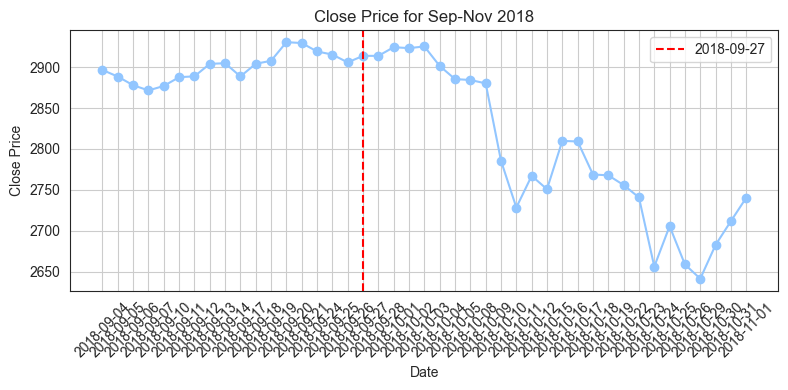

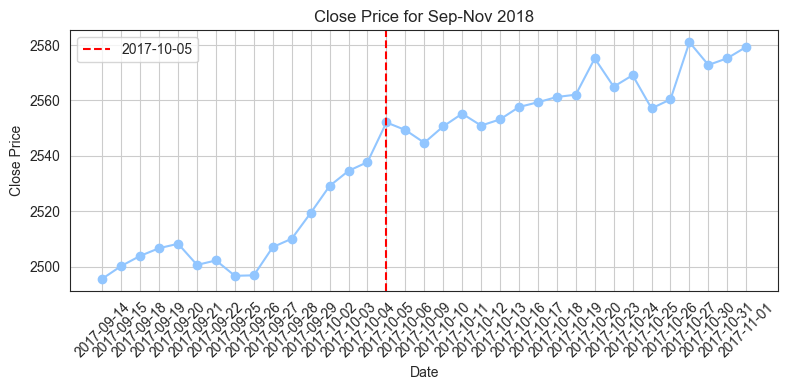

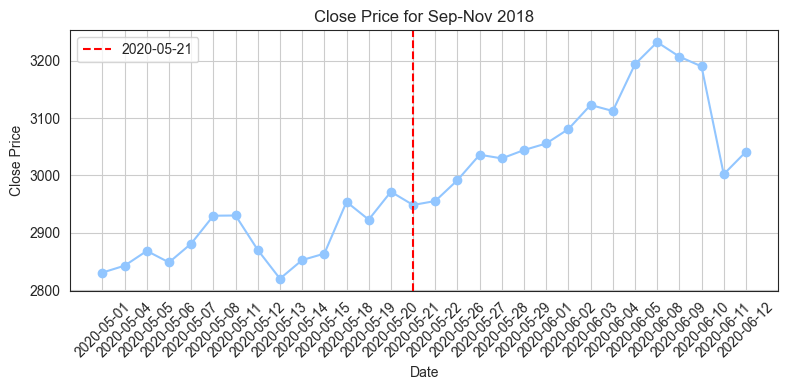

In [92]:
# 1
start_date = '2018-09-01'
end_date = '2018-11-01'
selected_data = sp500[(sp500['Date'] >= start_date) & (sp500['Date'] <= end_date)]

plt.figure(figsize=(8, 4))
plt.plot(selected_data['Date'], selected_data['Close'], marker='o', linestyle='-')
plt.axvline(x='2018-09-27', color='red', linestyle='--', label='2018-09-27')  # Dodaj linię dla 9 listopada
plt.title('Close Price for Sep-Nov 2018')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()  
plt.grid(True)
plt.tight_layout()

plt.show()

# 2 2017-10-05
start_date = '2017-09-14'
end_date = '2017-11-01'
selected_data = sp500[(sp500['Date'] >= start_date) & (sp500['Date'] <= end_date)]

plt.figure(figsize=(8, 4))
plt.plot(selected_data['Date'], selected_data['Close'], marker='o', linestyle='-')
plt.axvline(x='2017-10-05', color='red', linestyle='--', label='2017-10-05') 
plt.title('Close Price for Sep-Nov 2018')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()  
plt.grid(True)
plt.tight_layout()

plt.show()

# 3 2020-05-21
start_date = '2020-05-01'
end_date = '2020-06-14'
selected_data = sp500[(sp500['Date'] >= start_date) & (sp500['Date'] <= end_date)]

plt.figure(figsize=(8, 4))
plt.plot(selected_data['Date'], selected_data['Close'], marker='o', linestyle='-')
plt.axvline(x='2020-05-21', color='red', linestyle='--', label='2020-05-21') 
plt.title('Close Price for Sep-Nov 2018')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()  
plt.grid(True)
plt.tight_layout()

plt.show()

### Summary on test data implementation 

We conducted sentiment analysis on Central Bank speeches to explore its potential impact on the S&P 500 index. Unfortunately, our results do not provide conclusive evidence of such an impact. This might be due to the fact that the index is influenced by various factors, and also the low sentiment scores, which mostly stayed within the range of 0.2. It's worth noting that the stock market is a complex environment, where the influence of multiple factors can make it challenging to clearly identify the specific impact of central bank sentiment. 

In [93]:
sp500['Daily_Return'].mean()

0.00030113895052337524

In [94]:
sp500['Daily_Return'].median()

0.0004798574284363699

In [95]:
dates_of_interest = ['2006-02-06', '2018-09-27', '2004-11-18', '2014-03-25', '2014-10-30',
                      '2019-10-01', '2022-09-28', '2022-05-24', '2010-05-08', '2014-03-05',
                      '2017-01-12', '2012-08-06', '2015-09-30', '2012-07-24', '2010-04-13',
                      '2020-05-05', '2019-04-02', '2021-11-09', '1999-06-10', '2010-04-08',
                      '2020-05-21', '2008-04-07', '2002-11-18', '2017-10-04', '2017-07-28']

returns = [0.0007832015153355076, 0.0027632870875580196, 0.0013622582378927106,
           0.004403939814465518, 0.0062301242403934864, -0.012258373372913245,
           0.019672139926234733, -0.008120797617175213, None, -5.335132643191631e-05,
           -0.0021448089967596173, 0.0023292692665812798, 0.019075555906861608,
           -0.009040932945028057, 0.0006854008197059169, 0.009040556385797371,
           1.745570720723677e-05, -0.003498775895770745, -0.011997260953432232,
           0.003374341747336196, -0.007773596407737116, 0.0015615985189088022,
           -0.010408572546959705, 0.0012467201713795006, -0.001341115577770502]

df_returns = pd.DataFrame({'Date': dates_of_interest, 'Return': returns})
df_returns['Return'] = pd.to_numeric(df_returns['Return'], errors='coerce')
average_return = df_returns['Return'].mean(skipna=True)

print(df_returns)
print("\nAverage Return:", average_return)

          Date    Return
0   2006-02-06  0.000783
1   2018-09-27  0.002763
2   2004-11-18  0.001362
3   2014-03-25  0.004404
4   2014-10-30  0.006230
5   2019-10-01 -0.012258
6   2022-09-28  0.019672
7   2022-05-24 -0.008121
8   2010-05-08       NaN
9   2014-03-05 -0.000053
10  2017-01-12 -0.002145
11  2012-08-06  0.002329
12  2015-09-30  0.019076
13  2012-07-24 -0.009041
14  2010-04-13  0.000685
15  2020-05-05  0.009041
16  2019-04-02  0.000017
17  2021-11-09 -0.003499
18  1999-06-10 -0.011997
19  2010-04-08  0.003374
20  2020-05-21 -0.007774
21  2008-04-07  0.001562
22  2002-11-18 -0.010409
23  2017-10-04  0.001247
24  2017-07-28 -0.001341

Average Return: 0.00024617765440331413
